# CSE 152 : Introduction to Computer Vision, Spring 2018 – Assignment 4

## Problem 1 (Programing): Corner detection (20 points)
In this section, we will implement a detector that can find corner features in our images. 

In [1]:
import numpy as np
import scipy as sp
from imageio import imread
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter

First read-in the image and create a gray-scale version.

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img_war = imread('./dino/dino1.png')
img_war_gray = rgb2gray(img_war)

### 1. (10 points) Filtering and Gradient
#### Implement a procedure that filters an image using a 2D Gaussian kernel.

Create Gaussian kernel by sampling a Gaussian function.  
Use built-in functions to perform convolution.  
The width of the kernel should be ±3σ. 

In [3]:
def gaussian(I, sigma):
    w = 3*2*sigma # width of the kernel
    z = (w + 1)/2 # middle zero point
    kernel = np.zeros([w,w])
    for x in range(w):
        for y in range(w):
            if kernel[x,y] == 0:
                v = np.exp(-((x-z)**2+(y-z)**2)/2/sigma**2)
                kernel[x,y] = v 
                kernel[y,x] = v # optimization for symmetric computation
    return sp.ndimage.filters.convolve(I,kernel)

Apply to image warrior1 for σ = 1, σ = 3, and σ = 5

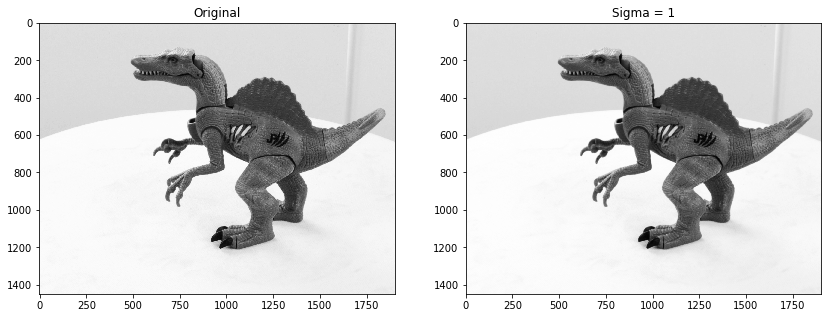

In [4]:
plt.gcf().set_size_inches(14,6)

plt.subplot(1,2,1)
plt.imshow(img_war_gray, cmap='gray')
plt.title('Original')

plt.subplot(1,2,2)
img_war_gray_gaussian_sigma1 = gaussian(img_war_gray, 1)
plt.imshow(img_war_gray_gaussian_sigma1, cmap='gray')
plt.title('Sigma = 1')

plt.show()

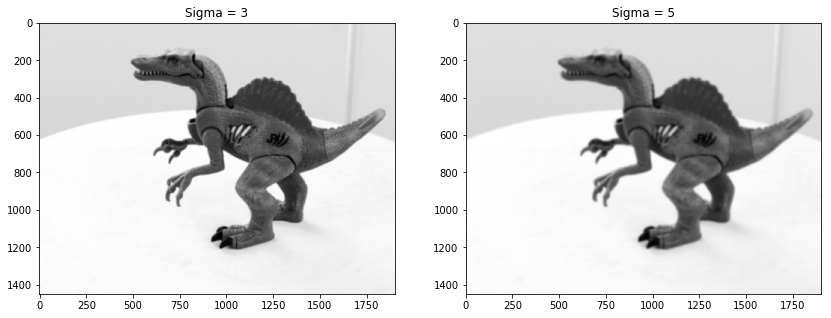

In [5]:
plt.gcf().set_size_inches(14,6)

plt.subplot(1,2,1)
img_war_gray_gaussian_sigma3 = gaussian(img_war_gray, 3)
plt.imshow(img_war_gray_gaussian_sigma3, cmap='gray')
plt.title('Sigma = 3')

plt.subplot(1,2,2)
img_war_gray_gaussian_sigma5 = gaussian(img_war_gray, 5)
plt.imshow(img_war_gray_gaussian_sigma5, cmap='gray')
plt.title('Sigma = 5')

plt.show()

#### Computes the horizontal and vertical gradients $Ix$ and $Iy$.

In [6]:
# like numpy.gradient
def gradient(m):
    x_c = np.rot90(np.array([[-1/2, 0, 1/2]]))
    y_c = x_c.transpose()
    x = sp.ndimage.filters.convolve(m,x_c)
    y = sp.ndimage.filters.convolve(m,y_c)
    return x,y

Include images of the two components of your gradient $Ix$ and $Iy$ on the image _warrior1_ for $σ = 1$, $σ = 3$, and $σ = 5$.<br>

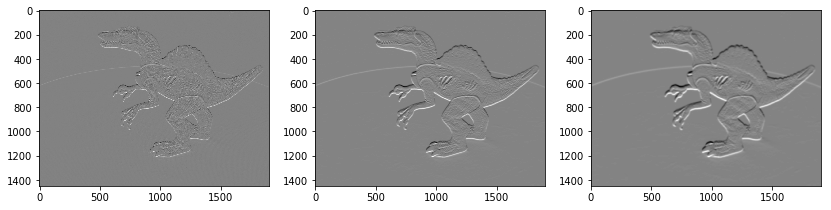

In [7]:
I_x_sigma1, I_y_sigma1 = gradient(img_war_gray_gaussian_sigma1)
I_x_sigma3, I_y_sigma3 = gradient(img_war_gray_gaussian_sigma3)
I_x_sigma5, I_y_sigma5 = gradient(img_war_gray_gaussian_sigma5)

plt.gcf().set_size_inches(14,6)

plt.subplot(1,3,1)
plt.imshow(I_x_sigma1, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(I_x_sigma3, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(I_x_sigma5, cmap='gray')

plt.show()

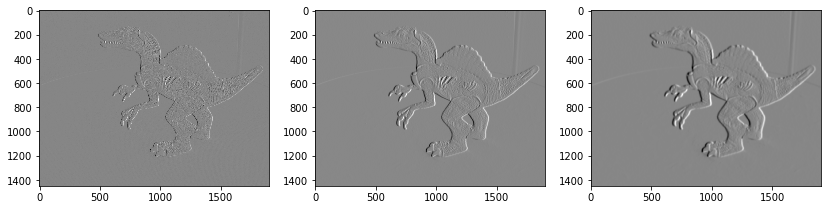

In [8]:
plt.gcf().set_size_inches(14,6)

plt.subplot(1,3,1)
plt.imshow(I_y_sigma1, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(I_y_sigma3, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(I_y_sigma5, cmap='gray')

plt.show()

#### 2. (10 points) Implement a procedure to detect corner points in an image. 

To detect corners, we rely on the matrix N defined as:

$$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. 

In [9]:
def N(I_x, I_y, w):
    I_x_sq = np.square(I_x)
    I_y_sq = np.square(I_y)
    I_xy = np.multiply(I_x, I_y)
    I_x_sq_sum = sp.ndimage.filters.convolve(I_x_sq, np.ones((w,w)))
    I_y_sq_sum = sp.ndimage.filters.convolve(I_y_sq, np.ones((w,w)))
    I_xy_sum = sp.ndimage.filters.convolve(I_xy, np.ones((w,w)))
    return np.swapaxes(np.swapaxes(np.array([[I_x_sq_sum, I_xy_sum],[I_xy_sum, I_y_sq_sum]]),0,2),1,3)

The corner detection algorithm should compute the minor (i.e., smallest) eigenvalue $\lambda_{min}$ of the matrix C at each pixel location in the image and use that as a measure of its cornerness score. 

In [10]:
def corner_score(I_x, I_y, w):
    score = np.empty_like(I_x)
    Ns = N(I_x, I_y, w)
    return np.amin(np.linalg.eigvals(Ns),axis=2)

Run non-maximal suppression, such that a pixel location is only selected as a corner if its minor eigenvalue is greater than that of its 8 neighboring pixels. 

In [11]:
def find_maximal(score):
    c = np.zeros_like(score)
    for i in range(8,len(c)-8):
        for j in range(8,len(c)-8):
            if score[i,j] == np.amax(score[i-8:i+9,j-8:j+9]):
                c[i,j] = 1
    return c

Have your corner detection procedure return the top n non-maximally suppressed corners. 

In [12]:
def corner_detect(image, nCorners, smoothSTD, windowsize):
    filtered = gaussian(image, smoothSTD)
    Iy, Ix = gradient(filtered)
    score = corner_score(Ix, Iy, windowsize)
    mask = find_maximal(score)
    corner = score * mask
    xy = np.stack(np.unravel_index(np.argsort(corner.ravel())[::-1],corner.shape),axis=-1)
    return xy[:nCorners]

Test your algorithm on warrior1 with n = 50 corners. Show corner detection results and report the parameters used.

In [13]:
def show_corners_result(imgs, corners):
    plt.imshow(imgs, cmap='gray')
    plt.scatter(corners[:, 1], corners[:, 0], s=35, edgecolors='r', facecolors='none')

Here are the parameters used: sigma = 10, and w = 50.

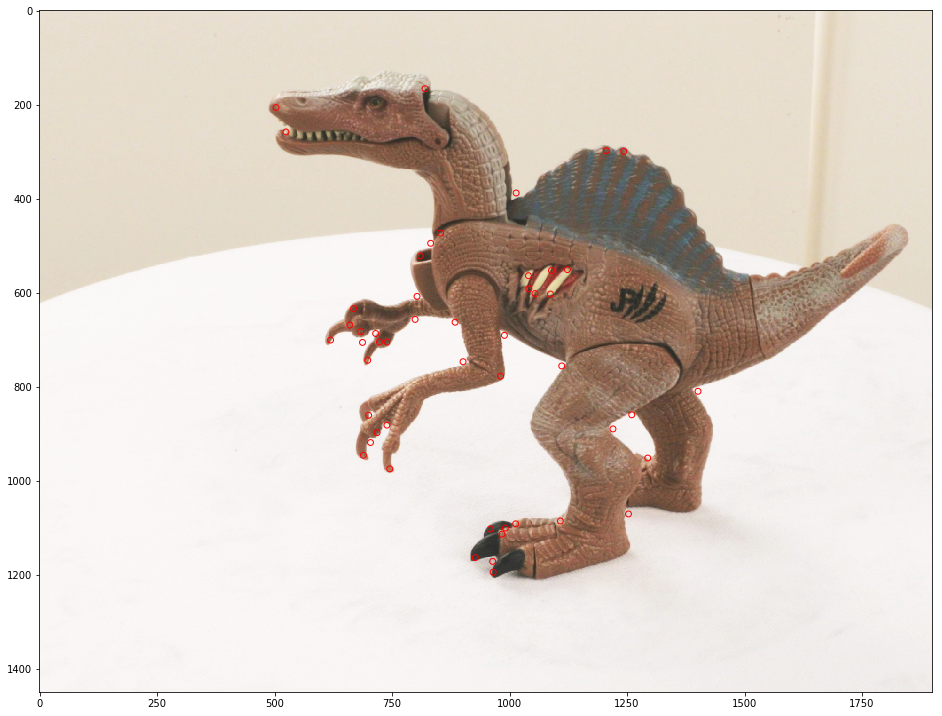

In [14]:
nCorners = 50
smoothSTD = 5
windowSize = 30

plt.gcf().set_size_inches(16,16)

crns_war = corner_detect(rgb2gray(img_war), nCorners, smoothSTD, windowSize)
show_corners_result(img_war, crns_war)

plt.show()

## Problem 2 (Programing): Sparse Stereo Correspondences (20 points)

For this part of this assignment, we will try to find correspondences between detected corners on stereo image pairs. 

Extract a 9×9 patch of neighboring pixels around each corner point x in warrior0 and corner point x’ in warrior1. 

In [15]:
def P(img1,i,j,img2,x,y,r=9):
    k = int((r+1)/2)
    l = int((r-1)/2)
    p1 = img1[i-l:i+k,j-l:j+k]
    p2 = img2[x-l:x+k,y-l:y+k]
    return p1, p2

The NSSD distance between two image patches P1 and P2 is the sum of squared differences between each pixel in the patch after normalizing each patch by their mean and variance. <br>
$$NSSD(W_1,W_2)=\sum_{i,j}\left | \tilde{W_1} (i,j) - \tilde{W_2} (i,j) \right |^2$$

In [16]:
def NSSD(p1, p2):
    return np.square(W(p1) - W(p2)).sum()

where 
$\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{k,l}(W(k,l) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window.

In [17]:
def W(p):
    return (p-p.mean())/p.std()/np.sqrt(p.size)

Consider matching x to a corner point x’ in warrior1 if the Normalized Sum of Squared Differences (NSSD) distance between the two patches is less than some threshold $\tau_{a}$ and the ratio of distance between closest match and next best match for x with other points is less than matching ratio $r_{match}$ (also check the same for x’) . This qualifies if corner pair (x,x’) is unique enough to be matched. 

In [18]:
def naive_stereo(imgs, corners, R, SSDth, R_match):
    matching = []
    imgs = imgs_war
    corners = crns_war
    atob = match_refine(imgs, corners, R, SSDth, R_match)
    btoa = match_refine(imgs[::-1], corners[::-1], R, SSDth, R_match, debug=1)
    for key, value in atob.items():
        if value in btoa.keys():
            if btoa[str(value)] == key:
                matching.append([np.fromstring(key[1:-1],sep=' '), np.fromstring(value[1:-1],sep=' ')])
    return np.array(matching)

In [19]:
debug_ratio = {}
debug_ssd = {}

def match_refine(imgs, crns, R, SSDth, R_match, debug = 0):
    best = {}
    img1, img2 = imgs
    corners1, corners2 = crns
    for i, c1 in enumerate(corners1):
        bestValue = SSDth
        bestIndex = np.nan
        secondBest = np.inf
        for j, c2 in enumerate(corners2):
            ssd = ssd_match(img1, img2, c1, c2, R)
            if ssd < bestValue:
                secondBest = bestValue
                bestValue = ssd
                bestIndex = j
        if not np.isnan(bestIndex) and bestValue/secondBest < R_match:
            best[str(c1)] = str(corners2[bestIndex])
            if(debug):
                debug_ratio[str(c1)] = bestValue/secondBest #record ratio
                debug_ssd[str(c1)] = bestValue #record distance
    return best

In [20]:
def ssd_match(img1, img2, c1, c2, R=4):
    p1, p2 = P(img1, c1[0], c1[1], img2, c2[0], c2[1], 2*R+1)
    return NSSD(p1, p2)

In [21]:
# detect corners on warrior sets
nCorners = 75
smoothSTD = 10 # what is the point of smoothing
windowSize = 65

# read images and detect corners on images
imgs_war = []
crns_war = []
for i in range(2):
    img_war = imread('./dino/dino' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    corner_war=corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize)
    crns_war.append(corner_war)

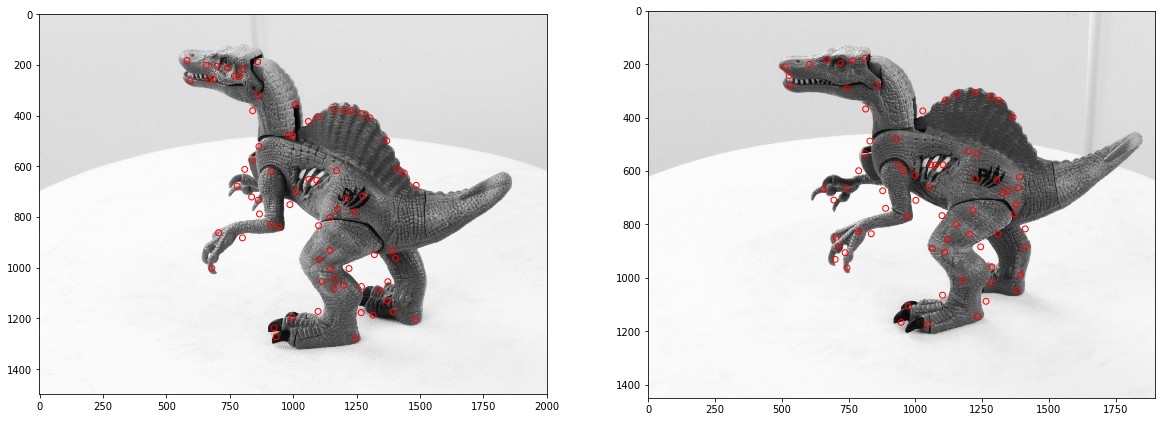

In [22]:
plt.gcf().set_size_inches(20,20)
plt.subplot(121)
show_corners_result(imgs_war[0],crns_war[0])
plt.subplot(122)
show_corners_result(imgs_war[1],crns_war[1])

Display the images of detected matches, and report the number of correct matches and the number of incorrect matches (by visual inspection). Specify which value of $\tau_{a}$ and $r_{match}$ you used.

In [23]:
# match corners
R = 50
SSDth = 0.7
R_match= 0.7

matching_war = naive_stereo(imgs_war, crns_war, R, SSDth, R_match)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


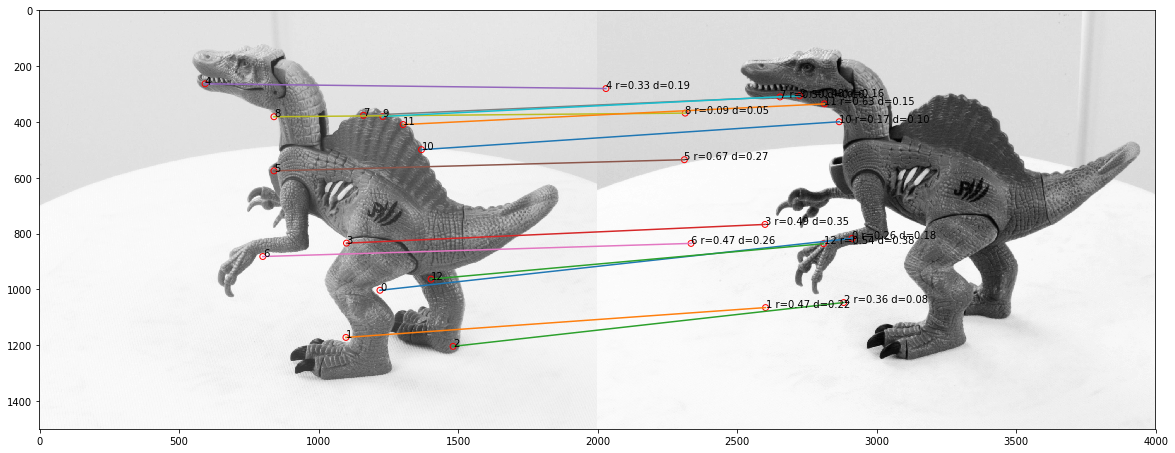

In [24]:
# plot matching result
def show_matching_result(img1, img2, matching):
    plt.imshow(np.hstack((img1, sp.misc.imresize(img2,img1.shape))), cmap='gray') 
    i=0
    for p1, p2 in matching:
        plt.scatter(p1[1], p1[0], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[1] + img1.shape[0], p2[0], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[1], p2[1] + img1.shape[0]], [p1[0], p2[0]])
        plt.annotate(i, (p1[1],p1[0]))
        indexStr = str(np.array((p2[0],p2[1])).astype(int))
        ratioNumber = debug_ratio[indexStr]
        ssdNumber = debug_ssd[indexStr]
        strToDisplay = str(i) + " r={:.2f}".format(ratioNumber) + " d={:.2f}".format(ssdNumber)
        plt.annotate(strToDisplay, (p2[1]+img1.shape[0],p2[0]))
        i=i+1
    plt.show()
     
plt.gcf().set_size_inches(20,10)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

All matches are correct.

In [25]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

## Problem 3 (Programing): Estimating the Fundamental Matrix (20 points)

The geometry of two camera views are related by the fundamental matrix F, which maps a point in one image to the corresponding epipolar line in the other image. Given eight or more image point correspondences x ↔ x’ between the two views, a linear estimate of the fundamental matrix can be computed using the direct linear transformation (DLT) algorithm. Typically before estimating the fundamental matrix from an image pair, one must perform outlier rejection (e.g., using RANSAC) in an attempt to remove false matches. However, for this problem we will assume that we have a set of relatively clean correspondences (i.e., no false matches) provided in cor1 and cor2.

### 1. (15 points) DLT Fundatmental Matrix Approximation

Implement linear estimation of the fundamental matrix using the DLT algorithm (with data normalization) by writing the function computeF_DLT(x, x') to estimate the fundamental matrix F. Do not forget to enforce the rank-2 constraint on the fundamental matrix. Using your developed computeF_DLT, estimate the fundamental matrix F from the point correspondences provided in cor1 and cor2<br>

In [26]:
x = np.load("./warrior/cor1.npy") #corners from image 1 to learn fundamental matrix
x_dash = np.load("./warrior/cor2.npy") # corresponding corners from image 2 to learn fundamental matrix
np.array(x).astype(int)[:,:5]

array([[ 692,  380,  273,  514,  628],
       [  82,  605,  478,  905, 1086],
       [   1,    1,    1,    1,    1]])

In [27]:
def T_DN(x):
    S = np.sqrt(2/(x[0].var() + x[1].var()))
    T = np.array([[S,0,-x[0].mean()*S],
                 [0,S,-x[1].mean()*S],
                 [0,0,1]])
    return T

In [28]:
def A(a, b):
    M = []
    for i in range(len(a[0])):
        M.append(np.array([np.kron(b[:,i], a[:,i])]).T)
    return np.array(M)[:,:,0]

In [30]:
def toHomo(x):
    return np.vstack((x,np.ones((1,x.shape[1]))))

def fromHomo(x):
    return x[:-1,:]/x[-1,:]

def computeF_DLT(x,x_dash): # inputs:
    T_DN_1 = T_DN(x)
    T_DN_2 = T_DN(x_dash)
    u, s, vh = np.linalg.svd(A(T_DN_1@x,T_DN_2@x_dash))
    n = np.array([vh[-1,:]]).T
    f_DN = np.reshape(n,(3,3))
    u2, s2, vh2 = linalg.svd(f_DN)
    s2[2]=0
    f_DN = np.dot(u2 * s2, vh2)
    F_DLT = T_DN_2.T @ f_DN @ T_DN_1

    return F_DLT/np.sqrt(np.sum(F_DLT**2))

F_DLT = computeF_DLT(x,x_dash)
F_DLT

NameError: name 'linalg' is not defined

### 2. (5 points) Epipolar Line

Additionally, in a separate figure, select any 3 points x in the warrior0 image not contained in cor1 and plot the corresponding epipolar lines l’ = Fx on warrior1. Each epipolar line should pass through the corresponding point in warrior1.

In [ ]:
def epipolar_lines(img1,img2, cor1, cor2, F):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)
        F: Fundamental Matrix
    output:
        point1: points in image1 (i.e. cor1)
        lines: corresponding lines in image 2

    """
    print(cor1)
    points1 = cor1
    lines = F @ points1
    return points1, lines ##return points and lines in the form of a tuple i.e. a tuple of three points and 
                            #a tuple of three lines

In [ ]:
I1 = imread('./warrior/warrior0.png')
I2 = imread('./warrior/warrior1.png')
from matplotlib.patches import Circle
from matplotlib.path import Path
import matplotlib.patches as patches
def draw_lines(img1, points1, img2, lines):
    # Use for plotting epipolar lines
    fig = plt.figure(figsize=(20,10))
    ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)

    # Plot points on img1
    ax1.imshow(img1, cmap='gray')
    for elem in points1:
        circ = Circle((elem[0], elem[1]),10)
        ax1.add_patch(circ)

    # Plot corresponding Epipolar lines on img2
    ax2.imshow(img2, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]
    for line in lines:
        slope = -1*line[0]/line[1]
        intercept = -1*line[2]/line[1]
        verts = [(0, slope*0+intercept), 
                 (img2.shape[1], slope*(img2.shape[1])+intercept)]
        path = Path(verts, codes)
        ax2.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()
points1,lines=epipolar_lines(I1,I2, toHomo(crns_war[0][0:3,:].T), toHomo(crns_war[1][0:3,:].T), F_DLT) 
draw_lines(I1,points1,I2,lines)